# This notebook is to extract feature importance from ML and use it to identify critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
import networkx as nx
from sys import platform 
from src.eda.subset_network import subset_network
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.models.ML_functions import *
from src.embedding.network_embedding import network_embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [19]:
emb_len16_walk100 = pd.read_csv('C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1/embedded_len16_walk100_cluster3+4.csv', index_col = 0)

In [21]:
processed_emb = process_emb_for_ML(emb_len16_walk100)

## Run ML 

In [4]:
lr = LogisticRegression(max_iter = 1000)
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [22]:
num_sample = processed_emb.impact.value_counts().min()
emb_subset = processed_emb.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
X_train, X_test, y_train, y_test = train_test_split(emb_subset.iloc[:, :64], emb_subset['impact'], test_size = 0.2)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
os.getcwd()

'C:\\Users\\bbche\\Documents\\GitRepos\\assist\\notebooks\\models'

In [121]:
# save the models
import pickle
pickle.dump(lr, open('../../data/emb_lr_Dec10.pkl', 'wb'))
pickle.dump(rf, open('../../data/emb_rf_Dec10.pkl', 'wb'))
pickle.dump(xgb, open('../../data/emb_xgb_Dec10.pkl', 'wb'))

In [119]:
# load saved models
with open(r'C:\Users\bbche\Documents\GitRepos\assist\data\emb_lr_Dec10.pkl', 'rb') as lr_model:
    saved_lr = pickle.load(lr)
with open(r'C:\Users\bbche\Documents\GitRepos\assist\data\emb_xgb_Dec10.pkl', 'rb') as rf_model:
    saved_rf = pickle.load(rf_model)
with open(r'C:\Users\bbche\Documents\GitRepos\assist\data\emb_xgb_Dec10.pkl', 'rb') as xgb_model:
    saved_xgb = pickle.load(xgb_model)

In [23]:
print('lr accuracy', lr.score(X_test, y_test))
print('rf accuracy', rf.score(X_test, y_test))
xgb_predict = xgb.predict(X_test)
print('xgb accuracy', accuracy_score(y_test, xgb_predict))

lr accuracy 0.6683937823834197
rf accuracy 0.7461139896373057
xgb accuracy 0.7046632124352331


In [24]:
def get_important_features(model):
    '''Get feature importances from models'''
    if type(model).__name__ == 'LogisticRegression':
        coef = model.coef_[0]
        coef = np.abs(coef) # convert coef to positive values only
        coef /= np.sum(coef) # convert coef to % importance
    else:
        coef = model.feature_importances_
    return coef

In [25]:
model_feature_importances = list(map(get_important_features, [lr, rf, xgb]))

In [26]:
def get_min_max_center(coef):
    '''A function to get min, max and avg used for heatmap in plot_feature_importances()'''
    min_value = coef.min()
    max_value = coef.max()
    center = np.mean([min_value, max_value])
    return min_value, max_value, center

In [27]:
def plot_feature_importances(model_coefs, model_names):
    '''A function to show feature importances in each model'''
    plt.figure(figsize = (7, 10))
    i = 0
    for coef in model_coefs:
        min_v, max_v, center = get_min_max_center(coef)
        plt.subplot(1,3,i+1)
        sns.heatmap(coef.reshape(64, 1), center = center, vmin = min_v, vmax = max_v)
        plt.title(model_names[i])
        plt.subplots_adjust(wspace = 2)
        i += 1

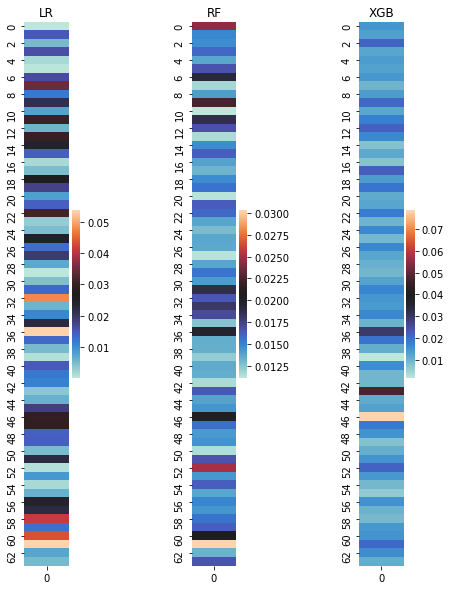

In [28]:
plot_feature_importances(model_feature_importances, ['LR', 'RF', 'XGB'])

## Extract top 20% important features 

In [29]:
def get_top_dim(coef, top_n_coef = 0.2):
    '''
    Get the top features used for each ML and return as a list along with id and abs_log2FC for the get_pairwise_distances()
    top_n_coef: 0.2 means extract features up to 20% importance
    '''
    for i in range(1, 64):
        if np.sum(coef[coef.argsort()[-i:]]) > top_n_coef:
            num_dim = i
            break 
    top_dim = [str(num) for num in coef.argsort()[-num_dim:]]
    top_dim += ['id', 'abs_log2FC']
#     emb_top_features = processed_emb_df[top_dim]
    return top_dim

In [30]:
top_feature_list = list(map(get_top_dim, model_feature_importances))

In [31]:
from sklearn.metrics.pairwise import euclidean_distances as ed

In [32]:
def get_pairwise_distances(processed_emb_df):
    '''Determine pairwise euclidean distance between each data point'''
    pairwise_distances = pd.DataFrame(ed(processed_emb_df.iloc[:, :-2]))
    pairwise_distances.columns = processed_emb_df['id']
    pairwise_distances.index = processed_emb_df['id']
    pairwise_distances['abs_log2FC'] = processed_emb_df['abs_log2FC'].tolist()
    pairwise_distances.sort_values('abs_log2FC', ascending = False, inplace=True)
    return pairwise_distances

In [33]:
pairwise_distance_list = list(map(get_pairwise_distances, [processed_emb[features] for features in top_feature_list]))

## Find critical genes based on distances to impact genes

In [103]:
from collections import Counter
def get_critical_genes(pairwise_distance_df):
    '''
    Find critical genes that are close to impact genes
    critical_gene_dict: # impact genes a critical gene is close to
    gene_pair_dict: pair the impact gene with their critical genes (based on distance) in a dictionary
    pairwise_distance_df: pairwise distance between the genes and sorted with abs_log2FC from high to low
    return critical_gene_dict: critical gene as keys, number of impact genes it's close to as the values
    gene_pair_dict: impact genes as keys and their corresponding critical genes as values
    '''
    critical_gene_list = []
    gene_pair_dict = {}
    size = len(pairwise_distance_df[pairwise_distance_df.abs_log2FC > 0.2]) # cutoff of abs_log2FC > 0.2 as impact gene
    for i in range(size):
        subset_distance = pairwise_distance_df.iloc[i,:-2].sort_values()
        key = subset_distance[subset_distance.between(0.01,0.55)].reset_index().columns[1] # Euclidean distance < 0.5 as "close", key is an impact gene
        values = subset_distance[subset_distance.between(0.01,0.55)].reset_index()['id'].tolist() # values are the list of close genes, aka potential critical genes
        gene_pair_dict[key] = values
        critical_gene_list += list(subset_distance[subset_distance.between(0.01,0.55)].index)
    critical_gene_dict = Counter(critical_gene_list)
    critical_gene_dict = sorted(critical_gene_dict.items(), key=lambda x: x[1], reverse=True)
    return critical_gene_dict, gene_pair_dict

In [104]:
# Note each item will contain 2 sets of values bc get_critical_genes return 2 sets of data
lr_critical_genes, rf_critical_genes, xgb_critical_genes = list(map(get_critical_genes, pairwise_distance_list)) 

In [37]:
def plot_critical_genes(emb_df, dim1, dim2, gene_pair_dict, critical_gene):
    plt.figure(figsize = (8,6))
    plt.scatter(emb_df[dim1], emb_df[dim2], s = 3, c = '#D3D3D3')
    for k,v in list(gene_pair_dict.items()): # loop through the distance dictionary to find the impact genes that are close to the critical genes
        if critical_gene in v:      
            plt.scatter(emb_df[emb_df.id == k][dim1], emb_df[emb_df.id == k][dim2], s = 5, c = 'b', label = 'impact gene') # Find the impact genes
    plt.scatter(emb_df[emb_df.id == critical_gene][dim1], emb_df[emb_df.id == critical_gene][dim2], s = 20, c = 'r', label = 'critical gene')
    plt.legend()

In [87]:
def common_critical_genes(critical_gene_lists, min_gene = 3):
    '''Find common critical genes between different models'''
    gene_lists = list(map(top_critical_genes, critical_gene_lists, [min_gene]*len(critical_gene_lists)))
    return set.intersection(*map(set,gene_lists))

In [89]:
def top_critical_genes(critical_gene_list, min_gene):
    return [i[0] for i in critical_gene_list[0] if i[1] >= min_gene]

In [105]:
common_critical_genes([lr_critical_genes, rf_critical_genes, xgb_critical_genes], 3)

{'ENSG00000001084',
 'ENSG00000100225',
 'ENSG00000124615',
 'ENSG00000140836',
 'ENSG00000140873',
 'ENSG00000151726',
 'ENSG00000163719',
 'ENSG00000168484'}

In [106]:
top_feature_list

[['58', '60', '32', '36', '61', 'id', 'abs_log2FC'],
 ['11', '6', '36', '46', '60', '9', '0', '52', '61', 'id', 'abs_log2FC'],
 ['12', '17', '36', '43', '46', 'id', 'abs_log2FC']]

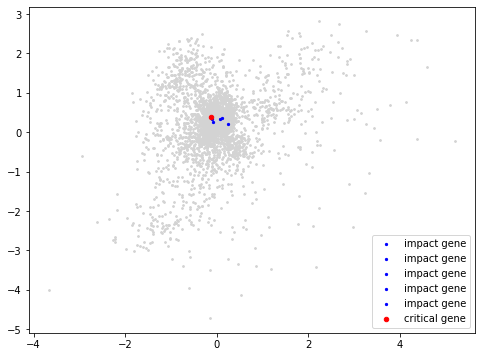

In [107]:
plot_critical_genes(processed_emb, '36', '61', lr_critical_genes[1], 'ENSG00000001084')

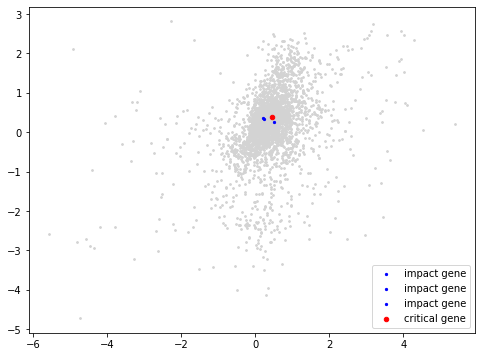

In [108]:
plot_critical_genes(processed_emb, '52', '61', rf_critical_genes[1], 'ENSG00000001084')

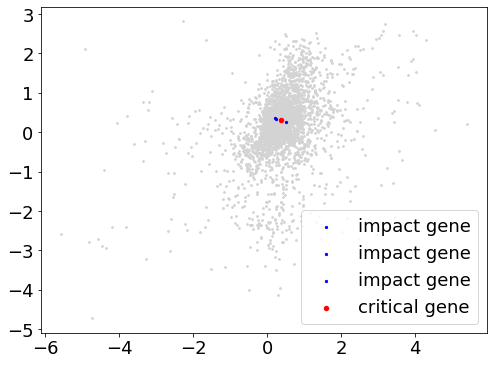

In [145]:
plot_critical_genes(processed_emb, '52', '61', rf_critical_genes[1], 'ENSG00000100225')

## Determine correlation between critical genes and alcohol phenotypes

In [134]:
critical_genes = ['ENSG00000001084', 'ENSG00000100225', 'ENSG00000124615', 'ENSG00000140836',
                  'ENSG00000140873', 'ENSG00000151726', 'ENSG00000163719', 'ENSG00000168484']

In [1]:
def gene_set_phenotype_corr(gene_sets, expression_meta_df = expression_meta):
    '''
    Plot correlation heatmap between critical gene sets and alcohol phenotypes
    '''
    i = 1
    phenotypes = ['BMI', 'Age', 'Brain_pH', 'Pack_yrs_1_pktperday_1_yr)', 'AUDIT', 
                  'alcohol_intake_gmsperday', 'Total_drinking_yrs', 'SR']
    for pheno in phenotypes:
        corr_list = []
        p_list = []
        corrected_p_list = []
        labels = []
        for genes in gene_sets:
            sub = expression_meta_df[[genes, pheno]]
            sub = sub.dropna()
            corr_list.append(pearsonr(sub[genes], sub[pheno])[0])
            p_list.append(pearsonr(sub[genes], sub[pheno])[1])
        corrected_p_list = multipletests(p_list, method ='fdr_bh')[1] # correct for multiple tests
        if i == 1:
            genes_corr = pd.DataFrame({pheno: corr_list})
            genes_pvalue = pd.DataFrame({pheno: corrected_p_list})
            i += 1

        else:
            genes_corr[pheno] = corr_list
            genes_pvalue[pheno] = corrected_p_list
    genes_corr.index = critical_genes
    genes_pvalue.index = critical_genes
    fig = plt.figure(figsize=(17, 8))
    plt.rcParams.update({'font.size': 18})
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # set the subplot width ratio
    # first subplot to show the correlation heatmap
    ax0 = plt.subplot(gs[0])
    sns.heatmap(genes_corr.sort_index(), cmap='RdBu_r', annot = True,
                annot_kws = {'fontsize':12}, vmin=-1, vmax=1, xticklabels = phenotypes) 
    plt.xticks(rotation = 45, ha = 'right')
    plt.ylabel('Gene ID')
    plt.title('Trait gene correlation')
    # second subplot to show count of significant traits in each cluster. "Significant" here means adj p value < 0.2
    ax1 = plt.subplot(gs[1])
    genes_pvalue = genes_pvalue
    sig_count = (genes_pvalue < 0.2).sum(axis = 1) # count num of traits with p-adj < 0.2 in each cluster
    sig_count = sig_count.sort_index(ascending = False)
    plt.barh(sig_count.index, sig_count.values) # horizontal bar plot
    plt.xlim(0,9) # there are 9 traits here so set the scale to between 0 and 9. change it if the # traits change
    plt.ylabel('Gene ID')
    plt.xlabel('Trait count')
    plt.title('Number of significant traits for each gene')
    plt.subplots_adjust(wspace = 1)

NameError: name 'expression_meta' is not defined

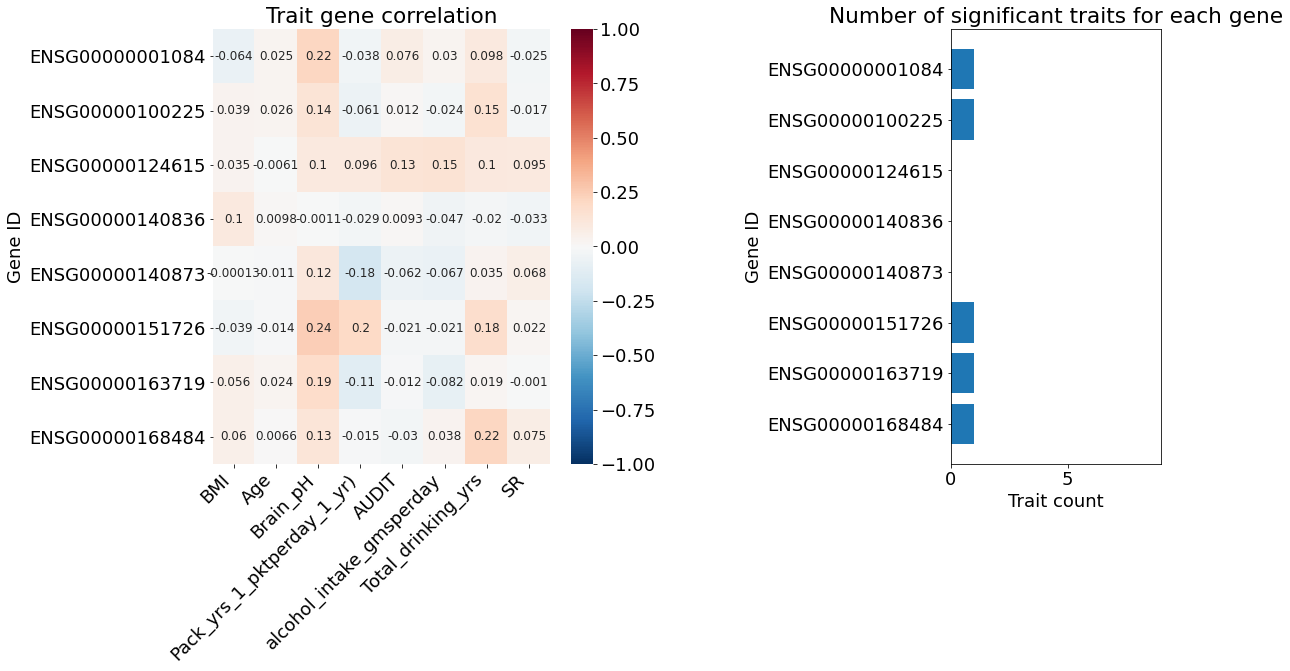

In [126]:
gene_phenotype_corr(critical_genes)

## Identify critical genes original modules

In [176]:
comm_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\network_louvain_default.csv')

In [178]:
comm_df[comm_df.id.isin(critical_genes)]

,id,louvain_label
7376,ENSG00000140836,3
7409,ENSG00000140873,3
12451,ENSG00000100225,3
12730,ENSG00000163719,3
14651,ENSG00000151726,3
16059,ENSG00000124615,3
16163,ENSG00000001084,3
17818,ENSG00000168484,3
